#Looqbox Data Challenge

###Candidato: Lucas Alexandre

#1 Importando as bibliotecas

In [5]:
import pymysql
import sqlalchemy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from wordcloud import WordCloud

sns.set_theme(style='whitegrid')
%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings('ignore')

#2 Criando a Engine de conexão ao banco de dados

In [ ]:
# Acessando o banco de dados
engine = sqlalchemy.create_engine('mysql+pymysql:secrets')
engine

In [ ]:
# Imprimindo as tabelas disponíveis
engine.table_names()

['IMDB_movies',
 'data_product',
 'data_product_sales',
 'data_store_cad',
 'data_store_sales']

#3 SQL test

## 3.1 What are the 10 most expensive products in the company?

In [ ]:
query_1 = '''
SELECT product_name as PRODUCT, product_val as VALUE
FROM data_product
ORDER BY product_val DESC
LIMIT 10
'''
top_expensives = pd.read_sql_query(query_1, engine)
top_expensives

,PRODUCT,VALUE
0,Whisky Escoces THE MACALLAN Ruby Garrafa 700ml...,741.99
1,Whisky Escoces JOHNNIE WALKER Blue Label Garra...,735.90
2,Cafeteira Expresso 3 CORACOES Tres Modo Vermelho,499.00
3,Vinho Portugues Tinto Vintage QUINTA DO CRASTO...,445.90
4,Escova Dental Eletrica ORAL B D34 Professional...,399.90
5,Champagne Rose VEUVE CLICQUOT PONSARDIM Garraf...,366.90
6,Champagne Frances Brut Imperial MOET Rose Garr...,359.90
7,Conjunto de Panelas Allegra em Inox TRAMONTINA...,359.00
8,Whisky Escoces CHIVAS REGAL 18 Anos Garrafa 750ml,329.90
9,Champagne Frances Brut Imperial MOET & CHANDON...,315.90


##3.2 What sections do the 'BEBIDAS' and 'PADARIA' departments have?

In [ ]:
# Opção 1 - Select Distinct
query_2a = '''
SELECT DISTINCT dep_name AS DEPARTMENT, section_name AS SECTION 
FROM data_product
WHERE dep_name IN ("bebidas", "padaria")
ORDER BY dep_name
'''
specific_sections = pd.read_sql_query(query_2a, engine)
specific_sections

,DEPARTMENT,SECTION
0,BEBIDAS,BEBIDAS
1,BEBIDAS,CERVEJAS
2,BEBIDAS,REFRESCOS
3,BEBIDAS,VINHOS
4,PADARIA,DOCES-E-SOBREMESAS
5,PADARIA,GESTANTE
6,PADARIA,PADARIA
7,PADARIA,QUEIJOS-E-FRIOS


In [ ]:
# Opção 2 - GROUP_CONCAT
query_2b = '''
SELECT dep_name AS DEPARTMENT, GROUP_CONCAT(DISTINCT section_name SEPARATOR ', ') AS SECTION
FROM data_product
WHERE dep_name in ('bebidas', 'padaria')
GROUP BY dep_name
'''

pd.options.display.max_colwidth = 60
specific_sections = pd.read_sql_query(query_2b, engine)
specific_sections

,DEPARTMENT,SECTION
0,BEBIDAS,"BEBIDAS, CERVEJAS, REFRESCOS, VINHOS"
1,PADARIA,"DOCES-E-SOBREMESAS, GESTANTE, PADARIA, QUEIJOS-E-FRIOS"


##3.3 What was the total sale of products (in $) of each Business Area in the first quarter of 2019?

In [ ]:
query_3 = '''
SELECT c.business_name AS "BUSINESS_AREA", SUM(s.sales_value) AS "SALES(Q1-2019)"
FROM data_store_cad c
JOIN data_store_sales s
ON c.store_code = s.store_code
WHERE YEAR(s.date) = 2019 AND QUARTER(s.date) = 1
GROUP BY c.business_name
'''
sales_Q1 = pd.read_sql_query(query_3, engine)
sales_Q1

,BUSINESS_AREA,SALES(Q1-2019)
0,Atacado,80384884.60
1,Farma,81776691.73
2,Posto,32072326.40
3,Proximidade,80171122.80
4,Varejo,81032347.65


#4 Python Cases

##4.1 The Dev Team was tired of developing the same old queries

In [ ]:
# Criando a função
def retrieve_data(product_code, store_code, date):
  """Return a dataframe based on dynamic query."""     
  
  first_date, last_date = date[0], date[1]
  query = """
  SELECT *
  FROM data_product_sales
  WHERE product_code = %s 
  AND store_code = %s
  AND date BETWEEN %s AND %s
  """     
  data = pd.read_sql_query(query, engine, params=[product_code, store_code,
                                                  first_date, last_date])
  
  if data.shape[0] != 0:  # Query bem-sucedida
    return data
  else:
    print('Não foi encontrado nenhum registro.')  # Query com resultado vazio

In [ ]:
# Aplicando a função
my_data = retrieve_data(18, 1, ['2019-01-01','2019-01-07'])
my_data

,STORE_CODE,PRODUCT_CODE,DATE,SALES_VALUE,SALES_QTY
0,1,18,2019-01-01,708.5,65.0
1,1,18,2019-01-02,1297.1,119.0
2,1,18,2019-01-03,1144.5,105.0
3,1,18,2019-01-04,1090.0,100.0
4,1,18,2019-01-05,893.8,82.0
5,1,18,2019-01-06,741.2,68.0
6,1,18,2019-01-07,654.0,60.0


##4.2 A brand new client sent you two ready-to-go queries

In [ ]:
# Executando a 1ª query do cliente
client_query = '''
SELECT
      STORE_CODE,
      STORE_NAME,
      START_DATE,
      END_DATE,
      BUSINESS_NAME,
      BUSINESS_CODE
FROM data_store_cad
'''
store_cad = pd.read_sql_query(client_query, engine)
store_cad.head()

,STORE_CODE,STORE_NAME,START_DATE,END_DATE,BUSINESS_NAME,BUSINESS_CODE
0,1,Sao Paulo,2006-10-01,,Varejo,1
1,2,Chicago,2007-10-01,,Varejo,1
2,3,Roma,2008-10-01,,Varejo,1
3,4,Tokio,2009-10-01,,Varejo,1
4,5,Paris,2019-01-01,,Proximidade,2


In [ ]:
store_cad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   STORE_CODE     20 non-null     int64 
 1   STORE_NAME     20 non-null     object
 2   START_DATE     20 non-null     object
 3   END_DATE       20 non-null     object
 4   BUSINESS_NAME  20 non-null     object
 5   BUSINESS_CODE  20 non-null     int64 
dtypes: int64(2), object(4)
memory usage: 1.1+ KB


In [ ]:
# Executando a 2ª query do cliente
client_query2 = '''
SELECT
        STORE_CODE,
        DATE,
        SALES_VALUE,
        SALES_QTY
FROM data_store_sales
WHERE DATE BETWEEN '2019-01-01' AND '2019-12-31'
'''
store_sales = pd.read_sql_query(client_query2, engine, parse_dates=['DATE'])
store_sales.head()

,STORE_CODE,DATE,SALES_VALUE,SALES_QTY
0,1,2019-01-01,196623.22,12838
1,10,2019-01-01,126795.44,4933
2,11,2019-01-01,223937.00,7724
3,12,2019-01-01,200251.80,7043
4,13,2019-01-01,196623.22,12838


In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7300 entries, 0 to 7299
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   STORE_CODE   7300 non-null   int64         
 1   DATE         7300 non-null   datetime64[ns]
 2   SALES_VALUE  7300 non-null   float64       
 3   SALES_QTY    7300 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 228.2 KB


In [ ]:
# Filtrando o período de vendas
mask = (store_sales['DATE'] >= '2019-10-01') & (store_sales['DATE'] <= '2019-12-31')
store_sales = store_sales.loc[mask]
store_sales.head()

,STORE_CODE,DATE,SALES_VALUE,SALES_QTY
5460,1,2019-10-01,187601.54,12160
5461,10,2019-10-01,139038.86,5223
5462,11,2019-10-01,252687.35,8481
5463,12,2019-10-01,223973.64,7659
5464,13,2019-10-01,187601.54,12160


In [ ]:
# Calculando o valor de TM por loja
store_sales_group = store_sales.groupby('STORE_CODE')['SALES_VALUE'].sum().reset_index()
store_sales_group['TM'] = round(store_sales_group['SALES_VALUE'] / 1000000, 2)
store_sales_group.head()

,STORE_CODE,SALES_VALUE,TM
0,1,21213088.57,21.21
1,2,21928421.28,21.93
2,3,21213088.57,21.21
3,4,21213088.57,21.21
4,5,21213088.57,21.21


In [ ]:
# Resposta do Case
df_final = pd.merge(store_cad, store_sales_group, how='left', on='STORE_CODE')
df_final = df_final.rename(columns={'STORE_NAME': 'Loja', 'BUSINESS_NAME': 'Categoria'})
df_final[['Loja', 'Categoria', 'TM']]

,Loja,Categoria,TM
0,Sao Paulo,Varejo,21.21
1,Chicago,Varejo,21.93
2,Roma,Varejo,21.21
3,Tokio,Varejo,21.21
4,Paris,Proximidade,21.21
5,Berlin,Proximidade,21.21
6,New York,Proximidade,21.21
7,Belem,Proximidade,20.99
8,London,Farma,19.47
9,Hong Kong,Farma,15.04


##4.3 Building your own visualizations

Nesta etapa, eu foquei primeiramente em perguntas relevantes a serem respondidas com o dataset e só depois pensei em quais seriam os melhores gráficos para respondê-las.

1. Quantos filmes foram lançados em cada ano? 
2. Quais são os 10 filmes com as maiores receitas? 
3. Quais são os 10 filmes de ficção científica com melhores avaliações? 
4. Como as variáveis numéricas se correlacionam?
5. Quais são as palavras mais frequentes em títulos bem e mal avaliados?



Motivos de seleção dos gráficos:

* Gráfico de barras e heatmap: são básicos e utilizados constantemente em análises exploratórias e modelagens preditivas. 
* WordCloud: é mais específico e utilizado apenas em certos contextos, porém, quando bem aproveitado traz informações bastante úteis.


###Importando os dados + Descrição inicial

In [ ]:
# Criando o dataframe a partir de uma query
my_query = '''
SELECT *
FROM IMDB_movies
'''
df_movies = pd.read_sql_query(my_query, engine)
df_movies.head()

,Id,Title,Genre,Director,Actors,Year,Runtime,Rating,Votes,RevenueMillions,Metascore
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe Saldana",2014,121,8.0,757074,333.0,76.0
1,2,Prometheus,"Adventure,Mystery,Sci-Fi",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fassbender, ...",2012,124,7.0,485820,126.0,65.0
2,3,Split,"Horror,Thriller",M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richardson, Jess...",2016,117,7.0,157606,138.0,62.0
3,4,Sing,"Animation,Comedy,Family",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth MacFarlane, ...",2016,108,7.0,60545,270.0,59.0
4,5,Suicide Squad,"Action,Adventure,Fantasy",David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola Davis",2016,123,6.0,393727,325.0,40.0


In [ ]:
df_movies.shape

(1000, 11)

In [ ]:
# Df com colunas numéricas de interesse
num_cols = df_movies.select_dtypes(include='number')
num_cols.drop('Id', axis=1, inplace=True)
num_cols.columns

Index(['Year', 'Runtime', 'Rating', 'Votes', 'RevenueMillions', 'Metascore'], dtype='object')

In [ ]:
# Estatística descritiva
num_cols.describe()

,Year,Runtime,Rating,Votes,RevenueMillions,Metascore
count,1000.000000,1000.000000,1000.00000,1.000000e+03,872.000000,936.000000
mean,2012.783000,113.172000,6.77300,1.698083e+05,82.943807,58.985043
std,3.205962,18.810908,0.98511,1.887626e+05,103.254260,17.194757
min,2006.000000,66.000000,2.00000,6.100000e+01,0.000000,11.000000
25%,2010.000000,100.000000,6.00000,3.630900e+04,13.000000,47.000000
50%,2014.000000,111.000000,7.00000,1.107990e+05,48.000000,59.500000
75%,2016.000000,123.000000,7.00000,2.399098e+05,114.000000,72.000000
max,2016.000000,191.000000,9.00000,1.791916e+06,937.000000,100.000000


###1. Quantos filmes foram lançados em cada ano?

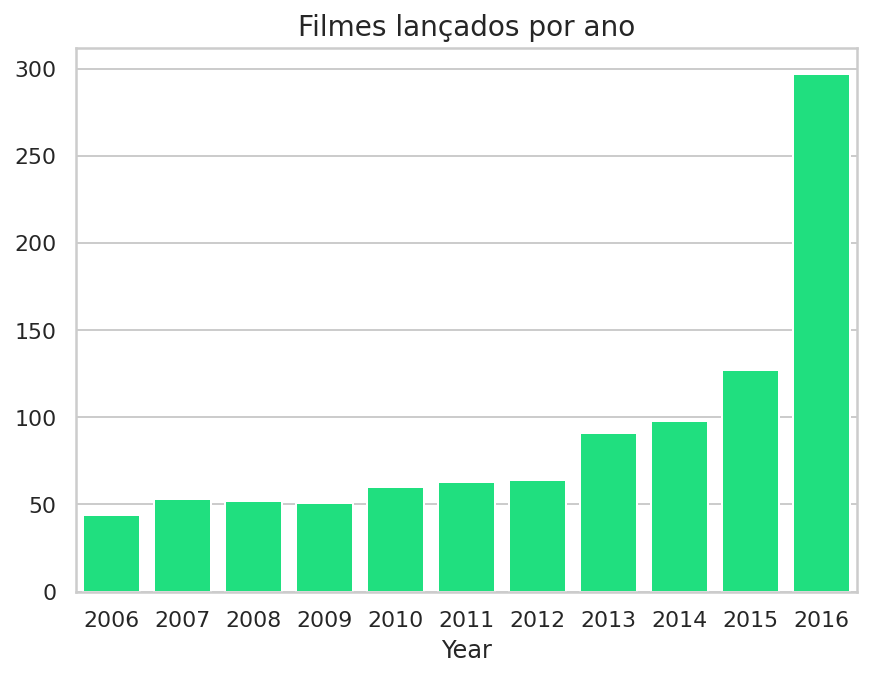

In [ ]:
# Gerando os dados
year_count = df_movies.groupby('Year')['Year'].count()

# Plotando o gráfico de barras
plt.figure(figsize=(7,5))
plt.title('Filmes lançados por ano', fontsize=14)
sns.barplot(x=year_count.index, y=year_count, color='springgreen')
plt.ylabel('')

plt.show()  

###2. Quais são os 10 filmes com as maiores receitas?

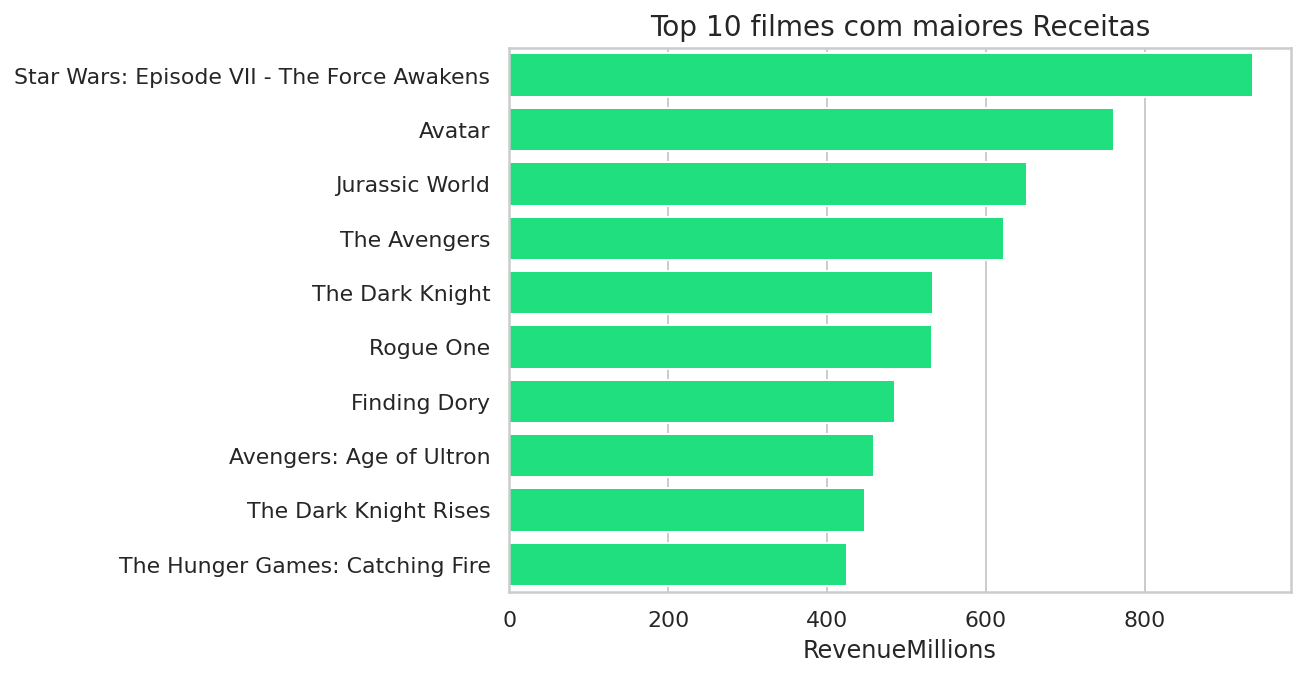

In [ ]:
# Gerando os dados
sort_revenue = df_movies.sort_values('RevenueMillions', ascending=False)
top_revenue = sort_revenue.head(10)

# Plotando o gráfico de barras
plt.figure(figsize=(7,5))
plt.title('Top 10 filmes com maiores Receitas', fontsize=14)
sns.barplot(x=top_revenue['RevenueMillions'], y=top_revenue['Title'], color='springgreen')
plt.ylabel('')

plt.show()

###3. Quais são os 10 filmes de ficção científica com melhores avaliações?

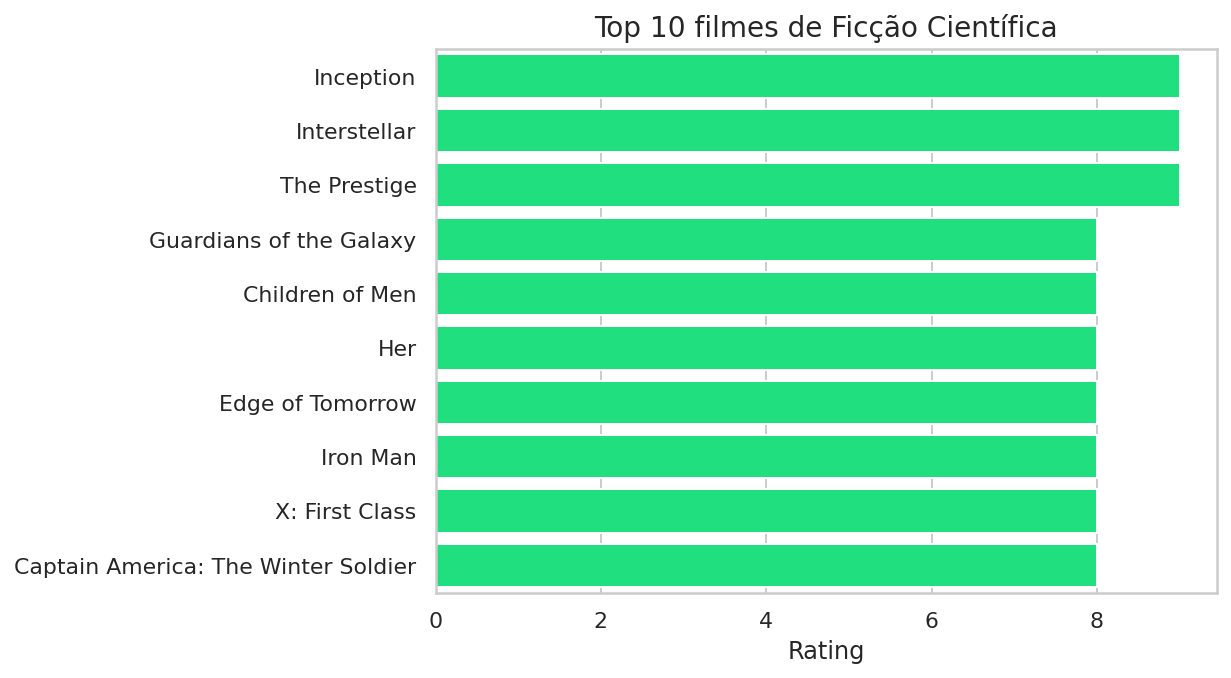

In [ ]:
# Gerando os dados
mask = df_movies['Genre'].str.contains('Sci-Fi')
scifi_movies = df_movies.loc[mask]
top_scifi = scifi_movies.sort_values('Rating', ascending=False).head(10)

# Plotando o gráfico de barras
plt.figure(figsize=(7,5))
plt.title('Top 10 filmes de Ficção Científica', fontsize=14)
sns.barplot(x=top_scifi['Rating'], y=top_scifi['Title'], color='springgreen')
plt.ylabel('')

plt.show()

* 3 filmes de ficção científica atingiram a nota máxima.

* Um fato curioso é que o diretor dos 3 foi o mesmo: Christopher Nolan.

In [ ]:
top_scifi[['Title', 'Director']]

,Title,Director
80,Inception,Christopher Nolan
36,Interstellar,Christopher Nolan
64,The Prestige,Christopher Nolan
0,Guardians of the Galaxy,James Gunn
246,Children of Men,Alfonso Cuarón
173,Her,Spike Jonze
200,Edge of Tomorrow,Doug Liman
203,Iron Man,Jon Favreau
205,X: First Class,Matthew Vaughn
216,Captain America: The Winter Soldier,Anthony Russo


###4. Como as variáveis numéricas se correlacionam?

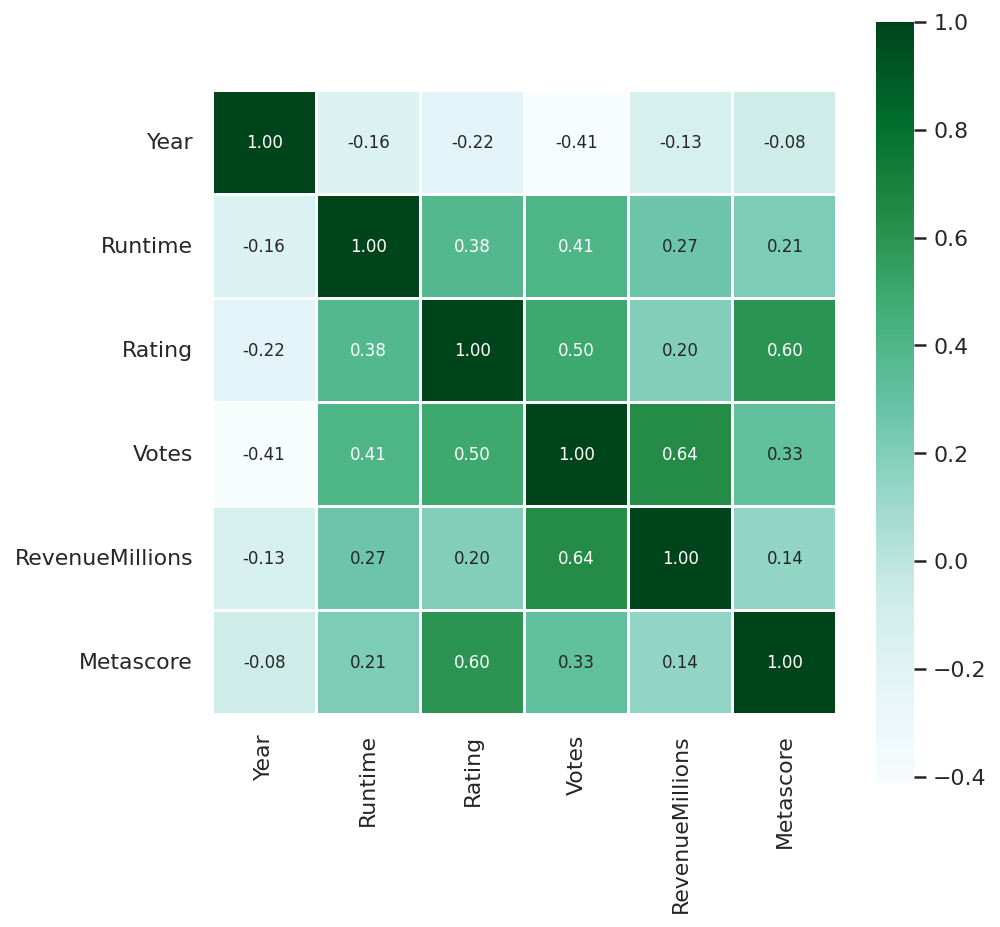

In [ ]:
# Plotando o Heatmap
heat = num_cols.corr()
plt.figure(figsize=(7,7))
sns.heatmap(heat, cmap='BuGn', square=True, linewidth=1, annot_kws={'fontsize':'small'}, annot=True, fmt='.2f')
plt.show()

###5.1 Quais são as palavras mais frequentes em títulos bem avaliados?

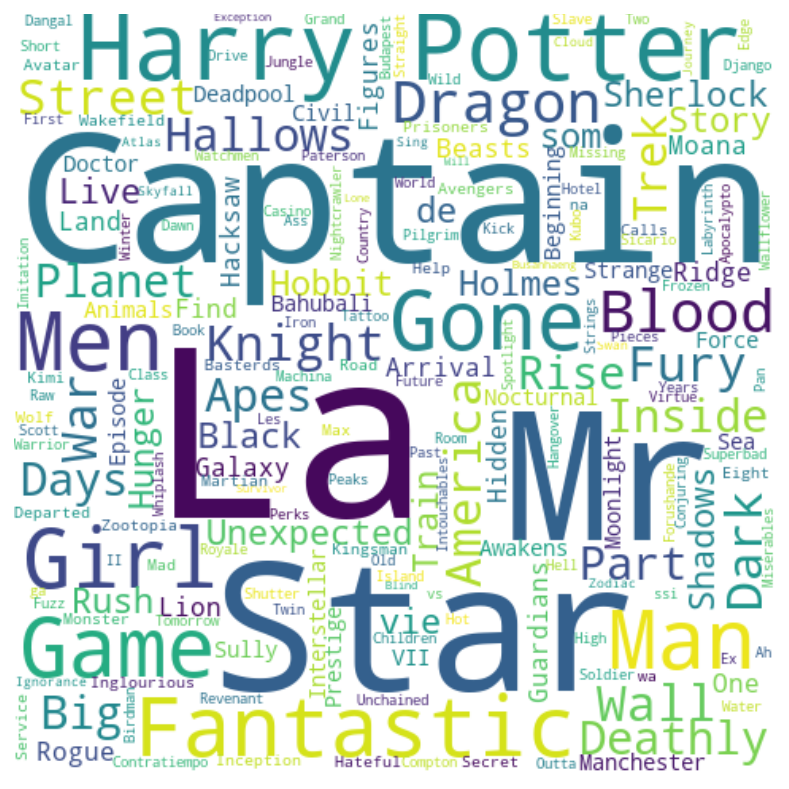

In [ ]:
# Gerando os dados de filmes bem avaliados
best_movies = df_movies.loc[df_movies['Rating'] >= 8.0]
best_text = " ".join(title for title in best_movies.Title)
wordcloud = WordCloud(background_color='white',max_font_size=150,   width=480, 
                      height=480, margin=0).generate(best_text)

# Plotando a Nuvem de palavras
plt.figure(figsize=(7,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

###5.2 Quais são as palavras mais frequentes em títulos mal avaliados?

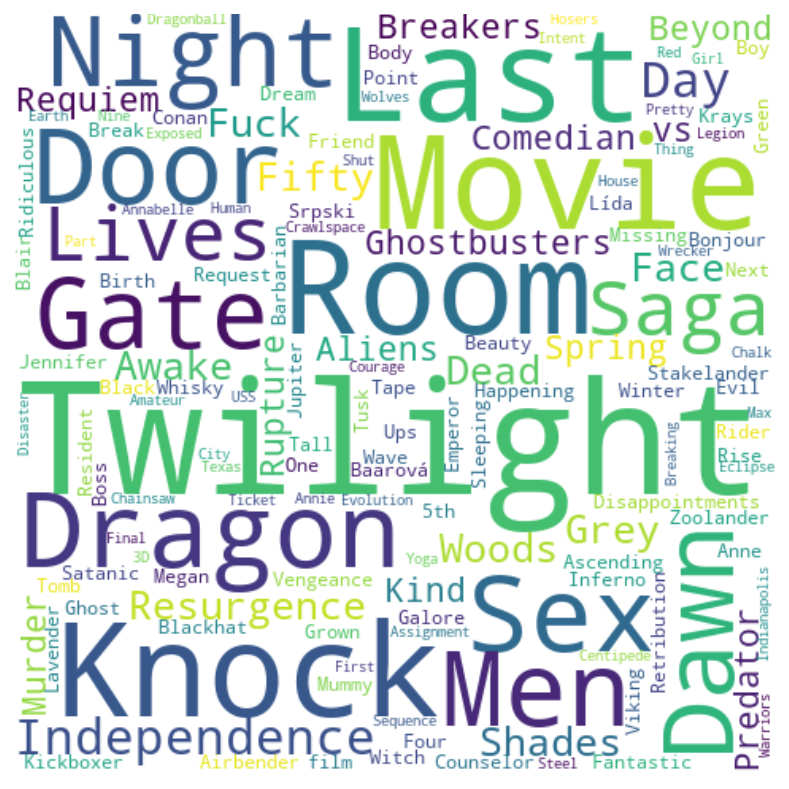

In [ ]:
# Gerando os dados de filmes mal avaliados
worst_movies = df_movies.loc[df_movies['Rating'] <= 5.0]
worst_text = " ".join(title for title in worst_movies.Title)
wordcloud = WordCloud(background_color='white',max_font_size=150, 
                      width=480, height=480, margin=0).generate(worst_text)

# Plotando a Nuvem de palavras
plt.figure(figsize=(7,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

#Fim✅, obrigado! 